In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  

Sprawdzenie czy CUDA działa

In [4]:
import torch
print("CUDA dostępne:", torch.cuda.is_available())
print("Wersja CUDA:", torch.version.cuda)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

CUDA dostępne: True
Wersja CUDA: 12.8
GPU: NVIDIA GeForce RTX 5060 Ti
Using cuda device


Dane

In [2]:
transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST('fashion_mnist/',train=True,download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.FashionMNIST('fashion_mnist_test/',train=False,download=True, transform=transform)
test_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)



Model

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), #Each example is 28x28 image
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10), #10 klas w Fashion Mist
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [40]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Funkcja kosztu i optymalizaotr

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Pętla treningowa

In [42]:
epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.4857
Epoch 2, Loss: 0.3611
Epoch 3, Loss: 0.3211
Epoch 4, Loss: 0.2981
Epoch 5, Loss: 0.2795
Epoch 6, Loss: 0.2643


Test modelu

In [43]:
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test accuracy: {100 * correct / total:.2f}%")

Test accuracy: 90.56%


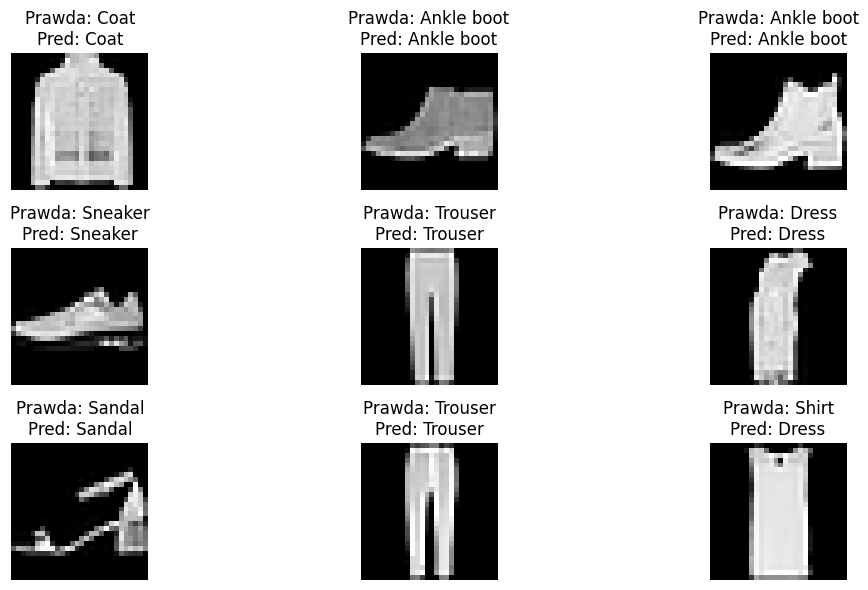

In [44]:
classes = train_dataset.classes

plt.figure(figsize=(12, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Prawda: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

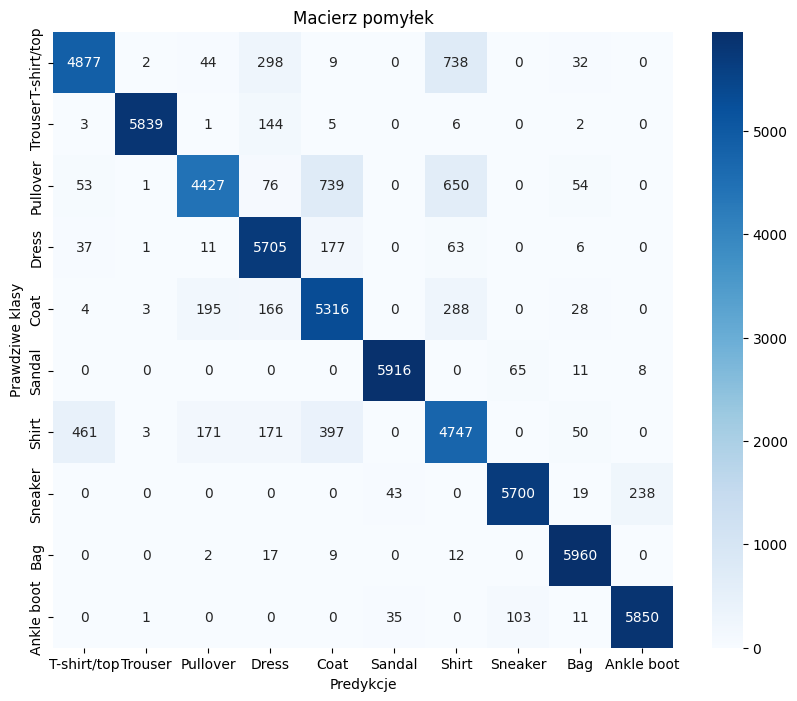

In [45]:
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.classes  # nazwy klas FashionMNIST

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe klasy')
plt.title('Macierz pomyłek')
plt.show()